## ref : https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

In [1]:
import numpy as np
import pandas as pd

import datetime
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [16, 10]

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


def show_table(df, sample_num=4, show_shape=True, show_na=True, dataset_nm=None):
    tail_num = sample_num//2
    head_num = sample_num-tail_num
    
    if dataset_nm is not None:
        dataset_nm = f'(in {dataset_nm}) '
    
    if show_shape:
        print(f'>>> shape {dataset_nm}: {df.shape}')
    if show_na:
        print(f'>>> number of NA {dataset_nm}: {df.isna().sum().sum()}')
    display(pd.concat([df.head(head_num), df.tail(tail_num)]))

/kaggle/input/new-york-city-taxi-with-osrm/fastest_routes_test.csv
/kaggle/input/new-york-city-taxi-with-osrm/accidents_2016.csv
/kaggle/input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv
/kaggle/input/new-york-city-taxi-with-osrm/second_fastest_routes_train.csv
/kaggle/input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv
/kaggle/input/new-york-city-taxi-with-osrm/second_fastest_routes_test.csv
/kaggle/input/new-york-city-taxi-with-osrm/test.csv
/kaggle/input/new-york-city-taxi-with-osrm/train.csv
/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip
/kaggle/input/nyc-taxi-trip-duration/test.zip
/kaggle/input/nyc-taxi-trip-duration/train.zip


## Data Understanding

In [2]:
train = pd.read_csv('../input/nyc-taxi-trip-duration/train.zip')
test = pd.read_csv('../input/nyc-taxi-trip-duration/test.zip')
sample_submission = pd.read_csv('../input/nyc-taxi-trip-duration/sample_submission.zip')

print('< Train dataset >')
show_table(train, sample_num=4)

print('\n\n< Test dataset >')
show_table(test)

< Train dataset >
>>> shape None: (1458644, 11)
>>> number of NA None: 0


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198




< Test dataset >
>>> shape None: (625134, 9)
>>> number of NA None: 0


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
625132,id1384355,1,2016-01-01 00:00:28,1,-73.976501,40.733562,-73.854263,40.891788,N
625133,id0621643,2,2016-01-01 00:00:22,2,-73.981850,40.716881,-73.969330,40.769379,N


- Columns 'dropoff_datetime' and 'trip_duration' are only available in train dataset.

In [3]:
print('id is unique') if train['id'].nunique() == train.shape[0] else print('There is redundant id')
print('Train and Test datasets are distinct') if np.intersect1d( train['id'], test['id'] ).shape[0]==0 else print('There is redundant id between train and test datasets')
print('Number of NA in train dataset :', train.isna().sum().sum())
print('Number of NA in test dataset :', test.isna().sum().sum())
print()
print('Unique values in store_and_fwd_flag :', pd.concat([train['store_and_fwd_flag'], test['store_and_fwd_flag']]).unique())
print('Min trip_duration (sec) :', train['trip_duration'].min())
print('Max trip_duration (sec) :', train['trip_duration'].max())
print(f'Max trip_duration (hour) : {train["trip_duration"].max()/3600:.2f}')

id is unique
Train and Test datasets are distinct
Number of NA in train dataset : 0
Number of NA in test dataset : 0

Unique values in store_and_fwd_flag : ['N' 'Y']
Min trip_duration (sec) : 1
Max trip_duration (sec) : 3526282
Max trip_duration (hour) : 979.52


In [4]:
train.dtypes.to_frame().T

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,object,int64,object,object,int64,float64,float64,float64,float64,object,int64


## Converting data types & Check the target feature

In [5]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

# New features - pickup_date, dropoff_date
train['pickup_date'] = train['pickup_datetime'].dt.date
test['pickup_date'] = test['pickup_datetime'].dt.date


train['check_trip_duration'] = train['dropoff_datetime'].subtract(train['pickup_datetime']).map(lambda x : x.total_seconds())
check_duration_diff = np.abs(train['check_trip_duration'].values - train['trip_duration'].values) > 1
print('>>> Warning! Check the difference between duration and datetime') if np.any(check_duration_diff) else print('>>> duration and datetime are ok')

print('>>> Max trip_duration :', train['trip_duration'].max()//3600)

>>> duration and datetime are ok
>>> Max trip_duration : 979


We can see that max trip duration is around 1000 hours. Fortunately, the evaluation metric is RMSLE, not RMSE. Outliers will cause less trouble. We could logtransform the target feature and use RMSE during training.

## Check the distribution of target feature (trip_duration, log_trip_duration)

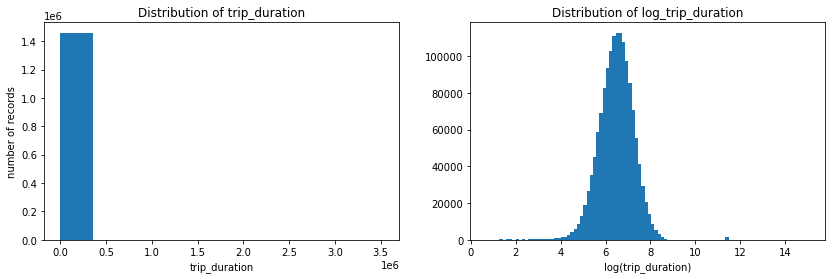

In [6]:
train['log_trip_duration'] = np.log1p(train['trip_duration'])


fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].hist(train['trip_duration'])
ax[0].set_title('Distribution of trip_duration')
ax[0].set_xlabel('trip_duration')
ax[0].set_ylabel('number of records')

ax[1].hist(train['log_trip_duration'], bins=100)
ax[1].set_title('Distribution of log_trip_duration')
ax[1].set_xlabel('log(trip_duration)')

plt.show()

## Validation Strategy
First let's check the train test split. It helps to decide our validation strategy and gives ideas about feature engineering.

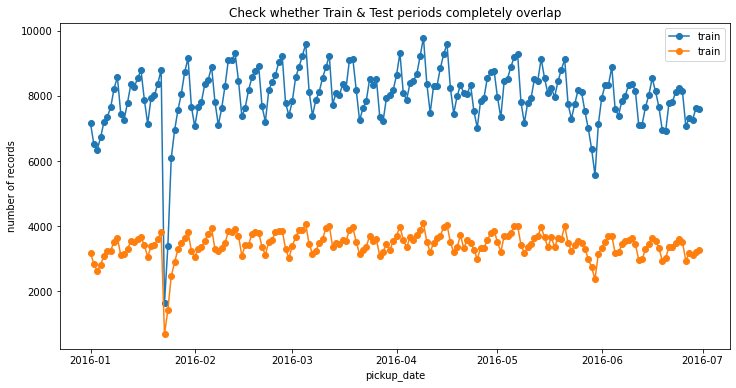

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(train.groupby('pickup_date')['id'].count(), '-o', label='train')
plt.plot(test.groupby('pickup_date')['id'].count(), '-o', label='train')
plt.title('Check whether Train & Test periods completely overlap')
plt.xlabel('pickup_date')
plt.ylabel('number of records')
plt.legend()
plt.show()

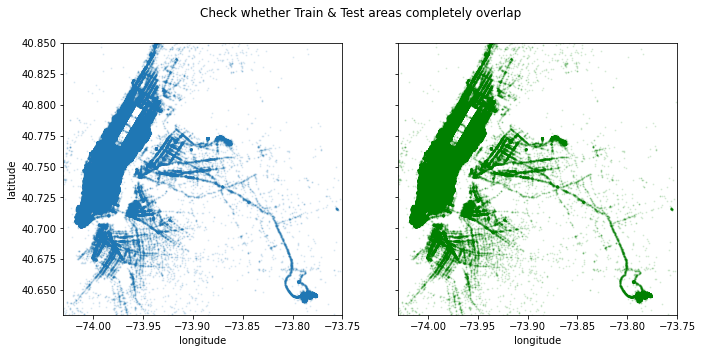

In [8]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(1, 2, figsize=(11, 5), sharex=True, sharey=True)

ax[0].scatter(train['pickup_longitude'].values, train['pickup_latitude'].values, alpha=0.1, s=1)
ax[1].scatter(train['pickup_longitude'].values, train['pickup_latitude'].values, color='green', alpha=0.1, s=1)

plt.suptitle('Check whether Train & Test areas completely overlap')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)

ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[1].set_xlabel('longitude')

plt.show()

In this case, the train and test split seems to be random. This allows us to use unsupervised learning and feature extraction to be applied on the full dataset.

## Feature Extraction 1. PCA
We use PCA to transform longitude and latitude coordinates. In this case it is not about dimension reduction since we transform 2D-> 2D. The rotation could help for decision tree splits.

In [9]:
coords = np.vstack((train[['pickup_latitude','pickup_longitude']].values,
                    train[['dropoff_latitude','dropoff_longitude']].values,
                    test[['pickup_latitude','pickup_longitude']].values,
                    test[['dropoff_latitude','dropoff_longitude']].values))

pca = PCA().fit(coords)

train['pickup_pca0'] = pca.transform(train[['pickup_latitude','pickup_longitude']].values)[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude','pickup_longitude']].values)[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude','dropoff_longitude']].values)[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude','dropoff_longitude']].values)[:, 1]

test['pickup_pca0'] = pca.transform(test[['pickup_latitude','pickup_longitude']].values)[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude','pickup_longitude']].values)[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude','dropoff_longitude']].values)[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude','dropoff_longitude']].values)[:, 1]

print(train.shape, test.shape)
show_table(train, show_shape=False, dataset_nm='train')

(1458644, 18) (625134, 14)
>>> number of NA (in train) : 0


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,check_trip_duration,log_trip_duration,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,455.0,6.122493,0.007691,0.017053,-0.009666,0.013695
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,663.0,6.498282,0.007677,-0.012371,0.027145,-0.018652
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,373.0,5.924256,0.008722,-0.001794,0.000817,0.005801
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198,2016-04-05,198.0,5.293305,0.004269,0.030689,-0.002967,0.039114


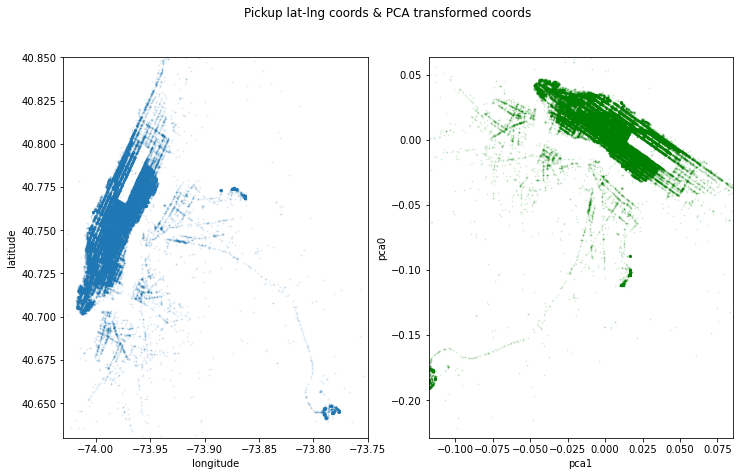

In [10]:
pca_borders = pca.transform([(lat, long) for lat, long in zip(city_lat_border, city_long_border)])

fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].scatter(train.head(100000).pickup_longitude, train.head(100000).pickup_latitude, s=1, alpha=0.1)
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')

ax[1].scatter(train.head(100000).pickup_pca1, train.head(100000).pickup_pca0, s=1, alpha=0.1, color='green')
ax[1].set_xlim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
ax[1].set_ylim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_xlabel('pca1')
ax[1].set_ylabel('pca0')

fig.suptitle('Pickup lat-lng coords & PCA transformed coords')
plt.show()

## Feature Extraction 2. Location features
- Trip Distance is the distance(km) between pickup and dropoff points. Currently haversine is used, but geopy has another heuristics. Since the cabs are not flying, it's also reasonable to check the Manhattan(L1) distance, too.
- I also extract the bearing(direction) between pickup and dropoff points.
- I also apply binning to latitude and longitude.

In [11]:
from haversine import haversine_vector

def dummy_manhattan_dist(df):
    horiz = haversine_vector(df[['pickup_latitude', 'pickup_longitude']], df[['pickup_latitude', 'dropoff_longitude']])
    vert = haversine_vector(df[['pickup_latitude', 'pickup_longitude']], df[['dropoff_latitude', 'pickup_longitude']])
    dist = horiz + vert
    return dist

def bearing_vector(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = np.radians([lat1, lng1, lat2, lng2])
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train['distance_haversine'] = haversine_vector(train[['pickup_latitude', 'pickup_longitude']], train[['dropoff_latitude', 'dropoff_longitude']])
train['distance_dummy_manhattan'] = dummy_manhattan_dist(train)
train['pca_manhattan'] = np.abs(train['dropoff_pca0'] - train['pickup_pca0']) + np.abs(train['dropoff_pca1'] - train['pickup_pca1'])
train['direction'] = bearing_vector(train['pickup_latitude'], train['pickup_longitude'], train['dropoff_latitude'], train['dropoff_longitude'])
train['center_lat'] = train['pickup_latitude'].add(train['dropoff_latitude']).divide(2)
train['center_lng'] = train['pickup_longitude'].add(train['dropoff_longitude']).divide(2)
train['pickup_lat_bin'] = train['pickup_latitude'].round(2)
train['pickup_lng_bin'] = train['pickup_longitude'].round(2)
train['center_lat_bin'] = train['center_lat'].round(2)
train['center_lng_bin'] = train['center_lng'].round(2)

test['distance_haversine'] = haversine_vector(test[['pickup_latitude', 'pickup_longitude']], test[['dropoff_latitude', 'dropoff_longitude']])
test['distance_dummy_manhattan'] = dummy_manhattan_dist(test)
test['pca_manhattan'] = np.abs(test['dropoff_pca0'] - test['pickup_pca0']) + np.abs(test['dropoff_pca1'] - test['pickup_pca1'])
test['direction'] = bearing_vector(test['pickup_latitude'], test['pickup_longitude'], test['dropoff_latitude'], test['dropoff_longitude'])
test['center_lat'] = test['pickup_latitude'].add(test['dropoff_latitude']).divide(2)
test['center_lng'] = test['pickup_longitude'].add(test['dropoff_longitude']).divide(2)
test['pickup_lat_bin'] = test['pickup_latitude'].round(2)
test['pickup_lng_bin'] = test['pickup_longitude'].round(2)
test['center_lat_bin'] = test['center_lat'].round(2)
test['center_lng_bin'] = test['center_lng'].round(2)

print(train.shape, test.shape)
show_table(train, show_shape=False, dataset_nm='train')

(1458644, 28) (625134, 24)
>>> number of NA (in train) : 0


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,distance_haversine,distance_dummy_manhattan,pca_manhattan,direction,center_lat,center_lng,pickup_lat_bin,pickup_lng_bin,center_lat_bin,center_lng_bin
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1.498523,1.735436,0.020716,99.970196,40.766769,-73.973392,40.77,-73.98,40.77,-73.97
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,1.805510,2.430509,0.025749,-117.153768,40.734858,-73.989948,40.74,-73.98,40.73,-73.99
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,1.092565,1.521852,0.015500,35.033294,40.753084,-73.978355,40.75,-73.98,40.75,-73.98
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,...,1.134044,1.548965,0.015661,29.969486,40.786167,-73.976173,40.78,-73.98,40.79,-73.98


## Feature Extraction 3. Datetime features

In [12]:
train['pickup_nth_sec'] = train['pickup_datetime'].subtract(train['pickup_datetime'].min()).dt.total_seconds()
train['pickup_nth_sec_bin'] = train['pickup_nth_sec'] // (3*3600)
train['pickup_minute'] = train['pickup_datetime'].dt.minute
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_hourofweek'] = train['pickup_datetime'].dt.dayofweek.multiply(24).add(train['pickup_hour'])
train['pickup_dayofweek'] = train['pickup_datetime'].dt.dayofweek
train['pickup_weekofyear'] = train['pickup_datetime'].dt.weekofyear

test['pickup_nth_sec'] = test['pickup_datetime'].subtract(test['pickup_datetime'].min()).dt.total_seconds()
test['pickup_nth_sec_bin'] = test['pickup_nth_sec'] // (3*3600)
test['pickup_minute'] = test['pickup_datetime'].dt.minute
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_hourofweek'] = test['pickup_datetime'].dt.dayofweek.multiply(24).add(test['pickup_hour'])
test['pickup_dayofweek'] = test['pickup_datetime'].dt.dayofweek
test['pickup_weekofyear'] = test['pickup_datetime'].dt.weekofyear

print(train.shape, test.shape)
show_table(train, show_shape=False, dataset_nm='train')

(1458644, 35) (625134, 31)
>>> number of NA (in train) : 0


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_lng_bin,center_lat_bin,center_lng_bin,pickup_nth_sec,pickup_nth_sec_bin,pickup_minute,pickup_hour,pickup_hourofweek,pickup_dayofweek,pickup_weekofyear
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,-73.98,40.77,-73.97,6369878.0,589.0,24,17,17,0,11
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,-73.98,40.73,-73.99,14085798.0,1304.0,43,0,144,6,23
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,-73.98,40.75,-73.98,402969.0,37.0,56,15,39,1,1
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,...,-73.98,40.79,-73.98,8261048.0,764.0,44,14,38,1,14


## Feature Extraction 4. Clustering

In [13]:
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords)

train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])

test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

print(train.shape, test.shape)
show_table(train, show_shape=False, dataset_nm='train')

(1458644, 37) (625134, 33)
>>> number of NA (in train) : 0


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,center_lng_bin,pickup_nth_sec,pickup_nth_sec_bin,pickup_minute,pickup_hour,pickup_hourofweek,pickup_dayofweek,pickup_weekofyear,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,-73.97,6369878.0,589.0,24,17,17,0,11,91,61
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,-73.99,14085798.0,1304.0,43,0,144,6,23,32,49
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,-73.98,402969.0,37.0,56,15,39,1,1,68,43
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,...,-73.98,8261048.0,764.0,44,14,38,1,14,29,37


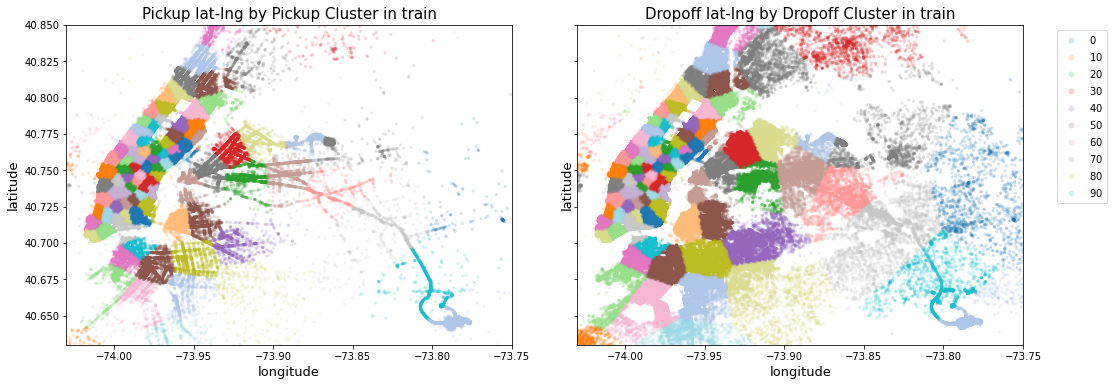

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)

for tmp_ax, col_header,  in zip(ax, ['pickup', 'dropoff']):
    scatter = tmp_ax.scatter(train[f'{col_header}_longitude'], train[f'{col_header}_latitude'], s=10, lw=0, alpha=0.2, c=train[f'{col_header}_cluster'], cmap='tab20')

    tmp_ax.set_xlim(city_long_border)
    tmp_ax.set_ylim(city_lat_border)
    tmp_ax.set_title(f'{col_header.capitalize()} lat-lng by {col_header.capitalize()} Cluster in train', size=15)
    tmp_ax.set_xlabel('longitude', size=13)
    tmp_ax.set_ylabel('latitude', size=13)
    
plt.legend(*scatter.legend_elements(), loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout(pad=3)

## Feature Extraction 5. OSRM Features
- I had only rough distance estimates in the previous versions. Now with the OSRM dataset, I can use better fastest route distance estimates between pickup and dropoff.

In [15]:
street_info_usecols = ['id', 'total_distance', 'total_travel_time', 'number_of_steps']

fr_train_1 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv', usecols=street_info_usecols)
fr_train_2 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv', usecols=street_info_usecols)
train_street_info = pd.concat([fr_train_1, fr_train_2], ignore_index=True)
train = train.merge(train_street_info, how='left', on='id')

test_street_info = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_test.csv', usecols=street_info_usecols)
test = test.merge(test_street_info, how='left', on='id')


display(train_street_info.head())
print(train.shape, test.shape)
show_table(train, show_shape=False, dataset_nm='train')

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


(1458644, 40) (625134, 36)
>>> number of NA (in train) : 3


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_minute,pickup_hour,pickup_hourofweek,pickup_dayofweek,pickup_weekofyear,pickup_cluster,dropoff_cluster,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,24,17,17,0,11,91,61,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,43,0,144,6,23,32,49,2513.2,332.0,6.0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,56,15,39,1,1,68,43,1628.3,161.6,7.0
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,...,44,14,38,1,14,29,37,1134.2,90.7,2.0
